Ce notebook est pour répondre à la partie 2 du tp2 de INF8111.

On doit aller chercher plusieurs tweets liés à l'actualité. Voici le lien vers les tweets id que nous devons utiliser: https://doi.org/10.7910/DVN/2FIFLH.

Il y a 39 695 156 tweets, ce qui prend 4.6 jours à extraire selon les limites de 900 requêtes (chaque requête pouvant contenir 100 tweets) par 15 minutes de twitter.

Nous devons faire une sélection des tweets que nous devons hydrater. Nous prenons un échanitllon de tweets ID pour créer notre .csv parmis tous les tweets id contenu dans le fichier news_outlet.txt (notre population). 

Si l'on prend l'hypothèse de la normalité dans notre population (i.e. que chaque attribut est normalement distirbué, ce qui est justifiable dû au très grand nombre d'observations et au théorème central limite), nous pouvons sélectionner un échantillon de taille acceptable pour s'assurer que la variance et la moyenne de notre échantillon soient similaires à ceux de la population.

À visiter: https://www.surveysystem.com/sscalc.htm

Une taille d'échantillon qui semble bien pourrait être d'environ 900 000 tweets (soit environ 2% de notre population). Si notre plan d'échantillonage est sans biais, 900 000 tweets semble une bonne taille (valider avec la calculatrice). Et, 900 000 observations reste encore très gérable localement sur nos machines (pas besoin de trop d'infrastructure). Devrait prendre environ 2.5 heures.

Mais, il faut considérer que nous voulons seulement des tweets en anglais et qu'en hydratant 900 000 tweets, les 900 000 ne seront pas tous en anlais. Selon des tests rapides préliminaires, environ 75% des tweets sont en anglais (nous avons eu 27 622 tweets en anglais parmis 36 754 hydratation). Ainsi, pour avoir 900 000 tweets en anglais, nous devrions environ hydrater 1 125 000 tweets.

On y va donc avec un 1 000 000 tweets rond, ce qui au maximum devrait prendre 3 heures (still realy manageable data extraction time). 

(peut-ête que plutot 300 000 tweets devraient être enough, vraiment juste à voir le temps à mettre/le bloquant d'attendre tout ce temps).

In [1]:
# Setup
import csv
import time
import random
import sys
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import string
import re
from scipy.sparse import csr_matrix
import math
import pickle
import scipy

from twython import Twython, TwythonError, TwythonRateLimitError

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

import nltk
import gensim



# On impose la seed du pseudo-random number generator pour assurer la répétabilité de nos résultats
random.seed(42)

Important d'assurer la répétabilité de nos résultats. Un des grand fléau du data science. Les gens font plein de trucs cool, génèrent des résultats, mais ne sont pas capable de les re-créer (eux-même ou d'autres personnes). Pour assurer la **qualité**, la **rigueur** et la **valeur** de nos résutlats/insights, il faut absolument que les résultats soient *reproducible* (ca vaut la peine de s'attarder sur ce point dans le rapport).

# Hydratation des tweets
On va shuffler au hasard toutes les lignes dans le fichier txt contenant le tweet handles.
On ne veut pas que notre échantillon possède un biais induit par la méthode d'acquisition des tweets ids de la part des gens qui ont créé le fichier. Par exemple, s'ils ont sélectionner tous les tweets d'un compte et ont mis ces tweets au début du fichier, si nous ne faisons que prendre les *N* premiers tweets id du fichier, alors notre échantillon va beaucoup plus représenter ce compte twitter que l'ensemble de la population.

In [2]:
# Credentials de Étienne Boisvenue

# Information de l'application
CONSUMER_KEY = "DUMMYDUMMY"
CONSUMER_SECRET = "DUMMYDUMMY"

# Information d'authentication
oauth_token = "DUMMY-DUMMY"
oauth_secret = "DUMMYDUMMY"

In [3]:
# On crée une ''porte'' vers twitter.
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, oauth_token, oauth_secret)

In [ ]:
%%time
# On shuffle le fichier texte (downloader du site que le prof à fourni)
# Prend environ  2 minutes
# Pas du tout la facon la plus optimale, mais ca fait la job pour nos besoins
# On fait ce shuffle juste une fois, assure un peu plus la représentativité de la population dans l'échantillon


lines = open('news_outlets.txt').readlines()
random.shuffle(lines)
open('shuffled_news_outlets.txt', 'w').writelines(lines)

In [4]:
random.seed(42)

Fonction pour hydrater la base de données. On crée des sous-ensemble de 100 tweets. On respecte le 15 minutes entre chaque.
Notre fonction est assez modulaire: on passe en argument *features* qui est une liste de liste. Ainsi, nous sommes facilement capable de naviguer les *nested dictionnaries*.





**Petit ajout de ce que Pierre-Étienne avait fait:**
Pour le header du csv, on ne met pas juste le dernier élément de la liste *key*. Nous avons *id* pour définir le *tweet id* et nous avons également *id* pour définir le *user id*. On a donc besoin de plusieurs éléments de la liste *key* pour définir l'attribut.

**ATTENTION!!!!!!!** En ce moment nous sommes hardcoder pour seulement accéder des données du tweet au premier ou deuxième niveau (de la manière dont le csv header est créé, voir dans def hydrate_database).

In [5]:
def hydrate_database(filename, database_name, 
                     features, nb_requests, 
                     tweet_hydratation_limit=100):
    """
    Create a csv file that contains features of tweets from an file that contains ID of tweets.
    
    filename: Name of the file that contains ids
    database_name: name of the file that will be created
    features: List of features
    nb_requests: number of time the function lookup_status will be called
    tweet_hydratation_limit:
    """
    # Opening the ID File:
    file = open(filename, "r")
    
    # On génère la list de Tweet Ids à envoyer à l'API.
    tweet_id = file.readline()

    lst_tweet_ids = []
    tweet_ids = []

    tweet_ids.append(tweet_id)

    while tweet_id:
        tweet_id = file.readline().rstrip('\r\n')
        tweet_ids.append(tweet_id)

        if len(tweet_ids) == tweet_hydratation_limit:
            lst_tweet_ids.append(",".join(tweet_ids))
            tweet_ids = []
    
    if len(tweet_ids) > 0:
        lst_tweet_ids.append(",".join(tweet_ids))
    
    # Creation of the file that will contain the hydrated tweets:
    with open(database_name, 'w', newline='', encoding="utf-8") as csvfile:  
        
        requestsMade = 0
        
        csvHeader = ''
        # On crée tout d'abord l'entête du csv
        for key in features :
            # Comme toutes les clés sont dans des listes, on ramasse la dernière clé de chaque liste, car ce
            # sont celles qui correspondront aux valeurs retournées.
            if len(key)==1:
                csvHeader += key[-1] + ','
            if len(key)==2:
                csvHeader += key[-2] +'_'+ key[-1] +','
                
            
        
        # On enlève la dernière virgule
        csvHeader = csvHeader[:-1] + '\n'
        
        # On écrit l'entête dans le fichier csv.
        csvfile.write(csvHeader)
        
        for i in range(0, len(lst_tweet_ids)):
            
            # Si on a atteint le nombre de requêtes maximal, on arrête d'itérer
            if requestsMade >= nb_requests:
                break
                
            tweetIds = lst_tweet_ids[i]
                
            try:
                # Effectue la requête à l'API
                tweets = twitter.lookup_status(id=tweetIds)
                
                # Comme la requête n'a pas lancé d'exception, on augmente de 1 le nombre de requêtes effectuées.
                requestsMade += 1
                
                print("Request count : " + str(requestsMade))
                
                #On ramasse le contenu des tweets
                for tweet in tweets:
                    csvLine = ''
                    
                    for key in features :
                        
                        # Utilisé pour aller chercher les sous-propriétés dans la structure du Tweet.
                        valueToFetch = tweet
                        
                        for subKey in key:
                            # S'il manque l'information voulue dans le tweet, on écrit une chaîne vide dans
                            # le csv et on passe au prochain ensemble de clé à rechercher.
                            if subKey not in valueToFetch:
                                valueToFetch = ''
                                break
                            
                            # On descend d'un niveau dans la structure du tweet, jusqu'à ce qu'on arrive à la
                            # sous-clé et valeur recherchée.
                            valueToFetch = valueToFetch[subKey]

                        # Une fois que la valeur associée à la sous-clé a été trouvée, on l'ajoute à la ligne
                        # du csv. On remplace aussi les newlines, les carriage return et les virgules par des
                        # espaces, histoire de s'assurer de l'intégrité du csv.
                        if valueToFetch is not None:
                            csvLine += str(valueToFetch).replace(',', ' ').replace('\r', ' ').replace('\n', ' ') + ','
                        else:
                            csvLine += ','

                    # On enlève la dernière virgule
                    csvLine = csvLine[:-1] + '\n'

                    # On écrit la ligne dans le fichier csv.
                    csvfile.write(csvLine)
                
            except TwythonError as e:
                if isinstance(e, TwythonRateLimitError):
                    retry_after = int(e.retry_after)
                    
                    # On attends le temps prescrit par l'API avant de recommencer.
                    print("We need to wait until : " + str(retry_after))
                    print('Current time:'+str(time.time()))
                    print('This is '+str(time.time()-retry_after)+' seconds')
                    
                    while time.time()< retry_after:
                        time.sleep(10)
                        print("We need to wait until : " + str(retry_after))
                        print('Current time:'+str(time.time()))
                    
                    # On décrémente l'index de l'itérateur pour réessayer avec les tweets qu'on a manqués
                    i -= 1
    
    print("Database hydratation complete.")
    
    file.close()


In [6]:
print(time.time())

1572444314.9057455


Maintenant on passe notre fichier shuffled à notre fonction qui hydrate. 

Pour l'instant je vais travailler avec un 5 fois 100 nombre de tweets (5 requêtes de 100 tweets chaque) et durant la nuit je vais lancer l'hydratation de 10 000 requêtes de 100 chaque, donc un million de tweets).

In [ ]:
filename = "shuffled_news_outlets.txt"
database_name = "news_more_features_10000_4.csv"
features = [['id'],
            ['created_at'],
            ['text'],
            ['user','id'],
            ['user','name'],
            ['user','screen_name'],
            ['user','location'],
            ['user','description'],
            ['user','followers_count'],
            ['in_reply_to_status_id'],
            ['lang']]
nb_requests = 10000

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=100)

On pre-process les tweets, exactement comme dans le tp1, mais on utilise des librairies optimisées plutôt que les version *homemade* que nous avions fait. L'objectif du tp2 n'est plus de nous introduire au technique (d'où pourquoi nous étions obligé de codé les techniques nous-même), mais plutôt de les appliqués. Nous avons démontré notre compréhension déjà des techniques de base de NLP pre-processing avec le tp1. 


- On load le document csv que l'on vient de créer avec les tweets hydrater.
- Ce .csv agit comme notre base de données.
- À partir d'ici, nous ne touchons plus du tout au Twitter API.

Au lieu de toute cette grosse fonction d'enfer, nous n'avons qu'à loader le .csv avec pandas

In [ ]:
df = pd.read_csv('news_more_features_10000.csv')

In [ ]:
print('Number of not NaN values for in_reply_to_status_id:')
print(len(df.loc[df['in_reply_to_status_id'].notnull()]))
print(df['in_reply_to_status_id'].value_counts())
print('\n')

print(df.columns)
print(df.dtypes)
df.head(5)

**Plus tard, lorsque les clusters seront fait, il serait vraiment intéressant de voir si les 6 tweets répondant au même tweet font partie de même clusters!!**

On veut changer le type de certaines colonnes.
- id doit devenir un string (object). On ne veut pas faire des mathématiques avec cet attribut, simplement avoir un identifiant unique pour chaque tweet
- created_at doit absolument être transformer dans un format de date quelconque
- user_id doit devenir un string (object) pour la meme raison que id
- in_reply_to_status_id doit devenir un string (en premier on transforme en int et ensuite en string pour ne pas conserver la notation scientifique du ''e'' représentant un exposant dans notre string final.




**IMPORTANT:** Le champ *in_reply_to_status_id* est très souvent vide. Nous avons rempli les NaN avec des -1. Permet de convertir en int et par la suite en str. Les tweet id ne peuvent pas être négatif. Pour simplement remplir le champ, on impose donc -1 comme valeur.

In [ ]:
%%time
# On fait toutes les conversions de types nécessaire

# in_reply_to_status_id devient in string. On rempli les NaN avec de -1
df['in_reply_to_status_id']=df['in_reply_to_status_id'].fillna(-1)
df['in_reply_to_status_id']=df['in_reply_to_status_id'].astype(int)
df['in_reply_to_status_id']=df['in_reply_to_status_id'].astype(str)


# id devient un string
df['id']=df['id'].astype(str)


# user_id devient un string
df['user_id']=df['user_id'].astype(str)

# created_at devient un format de date
df['created_at'] = pd.to_datetime(df['created_at'])
# Il est également possible de trier les lignes par ordres chronologiques:
# df.sort_values(by='created_at')




print(df.dtypes)

In [ ]:
df_eng = df.loc[df['lang'] == 'en']
df_eng=df_eng.reset_index()

# On crée un échantillon de df_eng, parce que 800 000 c'est overkill. 
# Mais au moins, on en a 800 000, si jamais on en veut méga beaucoup
df_sample=df_eng[0:100000]

print(df.shape)
df.head(5)

In [ ]:
print(df_eng.shape)
df_eng.head(5)

On dump (sauvegarde) les dataframe (df, df_eng et df_sample) qui ont été pre-processed (transformer les dates est assez long). 

In [4]:
# On dump les dataframe qui ont été pre-processed.
# C'est assez long de transformer created_at en format datetime (environ 2 minutes)

#df.to_pickle("df.pkl")
#df_eng.to_pickle("df_eng.pkl")
#df_sample.to_pickle("df_sample.pkl")


df = pd.read_pickle("preprocessing/df.pkl")
df_eng = pd.read_pickle("preprocessing/df_eng.pkl")
df_sample = pd.read_pickle("preprocessing/df_sample.pkl")

In [5]:
print(df.shape)
print(df_eng.shape)
print(df_sample.shape)
df.head()


(944720, 11)
(803951, 12)
(100000, 12)


,id,created_at,text,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,in_reply_to_status_id,lang
0,758300552702726146,2016-07-27 13:58:34+00:00,Bodycam video shows Iowa football player searc...,44433231,Clinton Herald,ClintonHerald,Clinton Iowa,Follow to receive updates on breaking news & s...,2492.0,-1,en
1,999006833284173826,2018-05-22 19:19:24+00:00,RT @UnivDeportes: #Rusia2018 ¡Excelentes notic...,16676396,El Universal,El_Universal_Mx,Centro de la Ciudad de México,Cuenta oficial de El Gran Diario de México. Co...,5203310.0,-1,es
2,877553008564948992,2017-06-21 15:45:16+00:00,A decision once seen as a threat to completion...,14801219,MinnPost,MinnPost,Minneapolis MN,Independent member-supported journalism for M...,91770.0,-1,en
3,708816415889891328,2016-03-13 00:46:17+00:00,All knotted up at 29 with FTs to go for Maumel...,55352444,Rock Town Sports,rocktownsports,Central Arkansas,NaN,1791.0,-1,en
4,908062696544899074,2017-09-13 20:19:52+00:00,Chance the Rapper is facing a lawsuit https://...,14089195,Pitchfork,pitchfork,Chicago/NYC,The most trusted voice in music.,3306998.0,-1,en


Donc, au final, nous avons environ 800 000 tweets en anglais que nous pouvons utiliser pour faire du clustering (but du tp = regrouper les news tweets en catégories).

# Exploration de nos données (statistiques descriptives)

**JE NE COMPREND PAS TROP POURQUOI LES HIST SONT LAIDS ET PK J'AI DE LA MISÈRE À METTRE LE PARAMÈETRE NBINS.....**


**Section qui démontre très bien notre rigeur et compréhension du dataset (pour le rapport). #JadeFaitDesStatDescrptiveCommeDansLautreCours**



Avant même de pre-process les tweets, nous voulons brièvement explorer les méta-données à propos des tweets que nous avons hydratés. 

In [52]:
# Distribution des langues
df['lang'].value_counts()

en     803951
es      39728
fr      16950
de      11608
und      9383
ar       8473
ja       8230
in       7141
hi       6201
ru       3885
pt       3409
tr       3009
ca       2667
nl       2376
iw       1935
ko       1854
it       1637
da       1572
bn       1234
el       1178
pl       1120
sv       1024
tl        720
fi        673
ro        631
ka        588
et        547
no        486
zh        410
ur        375
sr        320
fa        314
ht        264
cy        218
bg         75
sl         72
lt         66
cs         58
uk         56
hu         38
eu         34
lv         21
is         17
mr         11
ne         11
ta          8
vi          4
Name: lang, dtype: int64

In [53]:
df_eng['lang'].value_counts()

en    803951
Name: lang, dtype: int64

Pour tout le reste de l'exploration et de l'analyse (bref, tout le reste du tp), nous allons nous concentrer sur df_eng, soit uniquemment les tweets en anglais.

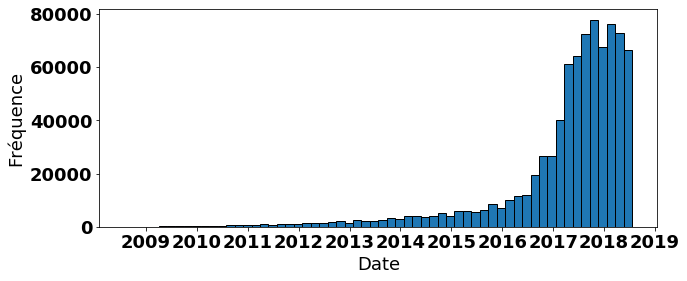

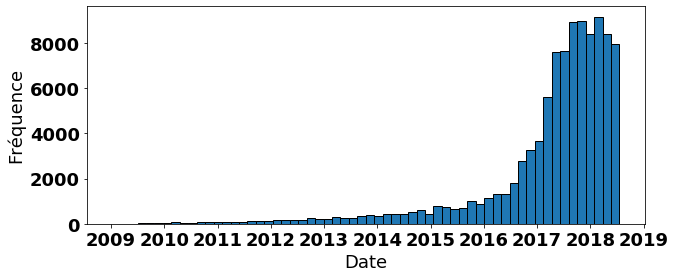

In [133]:
from scipy.optimize import curve_fit

def fit_function(x, A, beta, B, mu, sigma):
    return (A * np.exp(-x/beta) + B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

# Distribution des tweet dans le temps
plt.figure(figsize=(10,4))
plt.hist(df_eng['created_at'].values,edgecolor='black',bins=60)
##########################################plt.title('Distribution des tweets dans le temps des 800 000 tweets')
plt.xlabel('Date')
plt.ylabel('Fréquence')
plt.show()

# Distribution des tweet dans le temps
plt.figure(figsize=(10,4))
plt.hist(df_sample['created_at'].values,edgecolor='black',bins=60)
###########################################################plt.title('Distribution des tweets dans le temps des 100 000 tweets')
plt.xlabel('Date')
plt.ylabel('Fréquence')
plt.show()






C:\Users\etien\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


[1.20725210e-06 2.06957502e-06 2.24203961e-06 2.93189795e-06
 7.76090633e-06 7.76090633e-06 7.76090633e-06 1.03478751e-05
 6.38118965e-06 7.76090633e-06 1.03478751e-05 1.27623793e-05
 1.06928043e-05 1.65566002e-05 1.67290648e-05 1.25899147e-05
 2.20754669e-05 2.29377898e-05 2.01783565e-05 2.63870815e-05
 3.12160899e-05 2.63870815e-05 2.81117274e-05 4.41509338e-05
 3.53552400e-05 4.03567129e-05 4.93248713e-05 4.05291775e-05
 4.63929734e-05 5.63959193e-05 6.41568257e-05 6.20872506e-05
 7.79539925e-05 7.48496299e-05 7.22626612e-05 9.22685530e-05
 1.03996145e-04 7.65742758e-05 1.32107872e-04 1.26589005e-04
 1.10377334e-04 1.21070139e-04 1.71774727e-04 1.53493481e-04
 1.95057446e-04 2.28515575e-04 2.29205434e-04 3.14575403e-04
 4.79968940e-04 5.65856304e-04 6.29668200e-04 9.68906039e-04
 1.30917867e-03 1.31952654e-03 1.54200586e-03 1.55028416e-03
 1.44646048e-03 1.57943067e-03 1.44835759e-03 1.37419781e-03]
[733415.7166088  733473.69952739 733531.68244599 733589.66536458
 733647.64828318 73

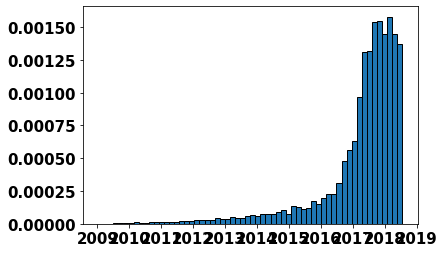

In [111]:
from scipy.optimize import curve_fit


def expo(x, a, b, c):
    return a * np.exp(-b * x) + c



hist, bins, patches = plt.hist(df_sample['created_at'].values,edgecolor='black',bins=60, normed=True)
print(hist)
print(bins)

new_bins=[]
for i in range(len(bins)-1):
    new_bins.append((bins[i]+bins[i+1])/2)
new_bins=np.array(new_bins)


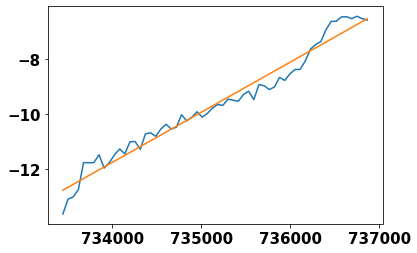

[ 1.81893025e-03 -1.34684917e+03]
0.8509454592391688


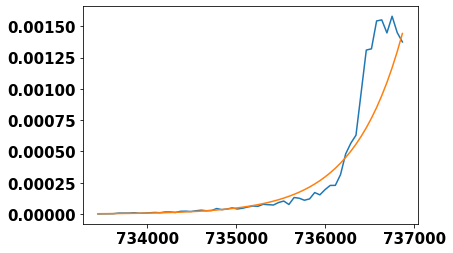

In [130]:
plt.figure()
plt.plot(new_bins,np.log(hist))
plt.plot(new_bins,fitting[1]+(fitting[0]*new_bins))
plt.show()

fitting=np.polyfit(new_bins, np.log(hist),1)
print(fitting)

from sklearn.metrics import r2_score
coefficient_of_determination = r2_score(hist, np.exp(fitting[1]+(fitting[0]*new_bins)))
print(coefficient_of_determination)


plt.figure()
plt.plot(new_bins,hist)
plt.plot(new_bins,np.exp(fitting[1]+(fitting[0]*new_bins)))
plt.show()



In [90]:
P = ss.expon.fit(hist)
print(1.2e-06*np.exp(0.000286*60))
print(hist[-1])
print (P)

1.2207696943163607e-06
0.0013741978142845816
(1.207252095882539e-06, 0.0002862337231141651)


In [ ]:
# On valide que le user_id est vraiment unique à un compte
df_eng['user_id'].loc[df_eng['user_name']=='The Independent']

In [14]:
# Distributions des comptes twitter présent dans notre base de données
df_sample['user_name'].value_counts()

Chaffey Breeze News        1045
The Independent             997
The Indian Express          690
The Guardian                601
NDTV                        600
The Hill                    486
Fox News                    442
BBC Sport                   438
Reuters                     422
Times of India              398
Business Insider            379
ABC News                    379
Inquirer                    376
The Irish Times             368
POLITICO                    340
Bloomberg                   310
allAfrica.com               309
The Washington Post         304
CNN                         295
RT                          287
Entertainment Weekly        279
The Wall Street Journal     276
Financial Times             270
Washington Examiner         266
CNET                        251
CNBC                        236
CBS News                    235
The New York Times          235
Daily Nation                233
The Boston Globe            230
                           ... 
The Ark 

In [ ]:
# Nombre d'auteur unique
print(len(df_eng['user_name'].value_counts()))

# Distribution du nombre de tweet par auteur
plt.figure(figsize=(15,4))
plt.hist(df_eng['user_name'].value_counts())
plt.title('Distribution du nombre de tweet par compte')
plt.xlabel('Nombre de tweet par compte')
plt.ylabel('Fréquence')
plt.show()

# Moyenne du nombre de tweet par compte 
print(np.mean(df_eng['user_name'].value_counts()))

# Médiane du nombre de tweet par compte
print(np.median(df_eng['user_name'].value_counts()))

In [ ]:
# Distribution du nombre de tweet par location.
# On a besoin de faire un effort d'harmonicité
df_eng['user_location'].value_counts()

In [ ]:
df_eng.iloc[11]

In [ ]:
# La moyenne est égal au nombre de followers, puisque le nombre de follower est le meme pour 
# tous les tweets provenant du même user. 
plt.figure(figsize=(15,4))
plt.hist(np.array(df_eng.groupby(['user_name']).mean()['user_followers_count']), edgecolor='black')
plt.title('Distribution du nombre de followers des users')
plt.xlabel('Nombre de followers')
plt.ylabel('Fréquence')
plt.show()

plt.figure()
plt.boxplot(np.array(df_eng.groupby(['user_name']).mean()['user_followers_count']), vert=False)
plt.show()

# Pre-processing
On va transformer tous et chacun de nos tweets on vecteur (tf-idf).

Nous utilisons des librairies pré-existantes.

On va donc:
- Enlever les URL
- Enlever les hashtags
- Enlever les digits (nombres)
- Enlever la ponctuation
- Tokenize
- Stemming
- Remove stop words (besoin d'avoir été mis en minuscule)
- Bigram
- TF-IDF

En premier, faisons tout ceci avec df_sample, juste pour voir c'est long comment.

Voici nos classe (principalement issues du TP1). 

In [ ]:
s = "string. With. Punctuation!@#C$@$C@C!#@#@$?#ÉV$#V@V#'@V'..q.w  ew 999q twee.q.c1.C#@!$"
table = str.maketrans(dict.fromkeys(string.punctuation))  # OR {key: None for key in string.punctuation}
new_s = s.translate(table)  
print(new_s)

In [9]:
class TwitterPreprocessing(object):

    def preprocess(self, tweet):
        """
        tweet: original tweet
        """
        # TODO : Write your preprocessing steps here.
        
        # On retire les hyperliens
        tweet = re.sub(r"http[^,]+\s*", "", tweet)
        
        # On retire les ''hashtags''
        tweet = re.sub(r"#\S+", "", tweet)
        
        # On retire la ponctuation
        table = str.maketrans(dict.fromkeys(string.punctuation))
        tweet= tweet.translate(table)  
        
        # On retire les digits
        tweet = re.sub(r"\d", "", tweet)

        # On retourne le tweet qui a été pre-processed
        new_tweet=tweet
        return new_tweet
    
class NLTKTokenizer(object):
    """
    This tokenizer uses the default function of nltk package (https://www.nltk.org/api/nltk.html) to tokenize the text.
    """

    def tokenize(self, text):
        # TODO
        tokens=[]
        tokenizer=TweetTokenizer()
        tokens=tokenizer.tokenize(text)

        # Have to return a list of tokens
        return tokens
    
class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=False)

    def stem(self, token):
        """
        tokens: a list of strings
        """
        # TODO
        token=self.stemmer.stem(token)
        
        # Have to return a list of stems
        return token
    
# On crée les instances des classes
processer= TwitterPreprocessing()
tokenizer=NLTKTokenizer()
stemmer=Stemmer()

**C'EST ICI QUE L'ON PEUT CHANGER ENTRE DF_SAMPLE ET DF_ENG**

In [18]:
%%time
# On extrait la colonne contenant les tweets littérallement. 
tweets=list(df_sample['text'])
#tweets=list(df_eng['text'])
new_tweets=list(np.zeros(len(tweets)))

# On enlève les URL, les hashtag, les nombres et les signes de ponctuation
for i in range (len(tweets)):
    new_tweets[i]=processer.preprocess(tweets[i])



Wall time: 2.93 s


In [19]:
%%time

# On tokenize tous les tweets

list_tokens=[]

# On tokenize tous les pre-processed tweets
for i in range(len(new_tweets)):
    list_tokens.append(tokenizer.tokenize(new_tweets[i]))




Wall time: 8.89 s


On fait le stemming.

In [20]:
%%time
# on a une liste dont chaque élément est une liste de tokens
list_tokens_stem=[]

# on loop sur chacun des élément de la liste
for j in range(len(list_tokens)):
    tokens=list_tokens[j]
    list_tokens_stem.append(list(map(stemmer.stem, tokens)))


Wall time: 34.6 s


In [21]:
number=99996
print(list_tokens[number])
print(list_tokens_stem[number])

['RT', 'HarvardHBS', 'Why', 'does', 'Germany', 'hire', 'amp', 'train', 'Syrian', 'refugees', 'We', 'look', 'at', 'the', 'economy', 'amp', 'the', 'human', 'connection', 'in', 'the', 'new']
['rt', 'harvardhb', 'whi', 'doe', 'germani', 'hire', 'amp', 'train', 'syrian', 'refuge', 'we', 'look', 'at', 'the', 'economi', 'amp', 'the', 'human', 'connect', 'in', 'the', 'new']


On enlève maintenant les stopwords

In [22]:
%%time
stop_words=stop_words = set(stopwords.words('english')) 
filtered_tokens=[]

# On loop sur tous les éléments de list_tokens_stem

for k in range(len(list_tokens_stem)):
    element=list_tokens_stem[k]
    filtered_element = [word for word in element if word not in stop_words]
    filtered_tokens.append(filtered_element)

Wall time: 588 ms


In [38]:
number=3
print(tweets[number])
print(filtered_tokens[number])

Chance the Rapper is facing a lawsuit https://t.co/P9RJvDX3aK
['chanc', 'rapper', 'face', 'lawsuit']


In [49]:
# On dump filtered tokens
print(type(filtered_tokens))
print(len(filtered_tokens))

with open('filtered_tokens.pkl', 'wb') as f:
    pickle.dump(filtered_tokens, f)
    
    
# On reload
with open('filtered_tokens.pkl', 'rb') as f:
    filtered_tokens = pickle.load(f)
    
print(type(filtered_tokens))
print(len(filtered_tokens))

<class 'list'>
100000
<class 'list'>
100000


Finalement, on crée une matrice de tf-idf, en incluant les bigrams.

On veut fit en ensuite transform.

On n'a pas de *train* et de *test*. On fait du unsupervised. Tout est dans le même bateau

In [39]:
# dummy function that returns what it has been passed. 
# Je ne savais pas que l'on pouvait inclure un pre-processor et un tokenizer directement dans TfidfVectorizer

def dummy_function(doc):
    return doc

In [40]:
%%time
# On commence sans bigram (le plus simple possible)


# http://www.davidsbatista.net/blog/2018/02/28/TfidfVectorizer/


# On crée l'instance du vectorizer
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_function,
    preprocessor=dummy_function,
    token_pattern=None) 

# on fit
tfidf.fit(filtered_tokens)

# on transforme
tfidf_mat= tfidf.transform(filtered_tokens)

Wall time: 3.1 s


In [41]:
print(tfidf_mat.shape)
print(len(filtered_tokens))
print(len(tfidf.vocabulary_))

(100000, 77440)
100000
77440


On dump tfidf_mat pour df_sample et df_eng.

**LOADING DES MATRICES TFIDF UNIGRAM**

In [42]:
##################################################################################### df_sample
#scipy.sparse.save_npz('tfidf_mat_sample.npz', tfidf_mat)
#tfidf_mat= scipy.sparse.load_npz('tfidf_mat_sample.npz')
#print(tfidf_mat.shape)


##################################################################################### df_eng
#scipy.sparse.save_npz('tfidf_mat_eng.npz', tfidf_mat)
#tfidf_mat= scipy.sparse.load_npz('tfidf_mat_eng.npz')
#print(tfidf_mat.shape)




(100000, 77440)


On peut maintenant utiliser la matrice *tfidf_mat* pour faire notre clustering. Chaque ligne de la matrice représente un tweet. Chaque colonne représente un mot dans notre vocabulaire. 

Notre vocabulaire est composé de 10 fois moins de mots que nous avons de tweets (lorsque l'on utilise df_sample). Donc en moyenne, nous avons environ un nouveau mot qui ne faisait pas déjà partie du vocabulaire par 10 tweets. 

**IL SERAIT INTÉRESSANT D'ALLER VOIR LE NOMBRE MOYEN DE FILTERED TOKEN PAR TWEET!!!**

Avant de commencer à faire du clustering, faisons une autre matrice qui contient également les bigrams.

In [43]:
%%time
# On crée l'instance du vectorizer de bigram
tfidf_bigram = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_function,
    preprocessor=dummy_function,
    ngram_range=(1,2),
    token_pattern=None) 

# on fit
tfidf_bigram.fit(filtered_tokens)

# on transforme
tfidf_bigram_mat= tfidf_bigram.transform(filtered_tokens)

Wall time: 12.3 s


In [44]:
print(len(tfidf_bigram.vocabulary_))
print(tfidf_bigram_mat.shape)

686253
(100000, 686253)


En ajoutant les bigrams, notre vocabulaire passe de 90 000 éléments à 760 000 éléments! (avec df_sample, nous n'avions pas encore enlever les digits et les signes de ponctuation dans le pre-processing).

In [ ]:
# On explore un peu les idf
plt.figure()
plt.hist(tfidf.idf_, edgecolor='black')
plt.show()


# dans inv_idf, les keys sont des positions et les values sont des idf
inv_idf = {v: k for k, v in tfidf.vocabulary_.items()}


# trouver le mot avec idf le plus petit (le plus commun)
print('Mot le plus commun')
print(min(tfidf.idf_))
print(np.argmin(tfidf.idf_))
print(inv_idf[np.argmin(tfidf.idf_)])

# trouver le mot avec idf le plus grand (le plus rare)
print('\nMot le plus rare')
print(max(tfidf.idf_))
print(np.argmax(tfidf.idf_))
print(inv_idf[np.argmax(tfidf.idf_)])


On dump tfidf_bigram_mat pour df_sampl et df_eng.

**LOADING DES MATRICE TFIDF DE BIGRAMS**

In [45]:
################################################################################ df_sample
#scipy.sparse.save_npz('tfidf_bigram_mat_sample.npz', tfidf_bigram_mat)
#tfidf_bigram_mat= scipy.sparse.load_npz('tfidf_bigram_mat_sample.npz')
#print(tfidf_bigram_mat.shape)


################################################################################ df_eng
#scipy.sparse.save_npz('tfidf_bigram_mat_eng.npz', tfidf_bigram_mat)
#tfidf_bigram_mat= scipy.sparse.load_npz('tfidf_bigram_mat_eng.npz')
#print(tfidf_bigram_mat.shape)

(100000, 686253)


On dump tfidf et tfidf_bigram pour df_sample et df_engé

**LOADING DES VECTORIZERS**

In [46]:
#pickle.dump(tfidf, open("tfidf_sample.pickle", "wb"))
#pickle.dump(tfidf, open("tfidf_eng.pickle", "wb"))
#pickle.dump(tfidf_bigram, open("tfidf_sample_bigram.pickle", "wb"))
#pickle.dump(tfidf_bigram, open("tfidf_eng_bigram.pickle", "wb"))






################################################################### sample
#with open(r"tfidf_sample.pickle", "rb") as input_file:
#    tfidf = pickle.load(input_file)
#    
#with open(r"tfidf_sample_bigram.pickle", "rb") as input_file:
#    tfidf_bigram = pickle.load(input_file)
   
#
#################################################################### eng
#with open(r"tfidf_eng.pickle", "rb") as input_file:
#    tfidf = pickle.load(input_file)
#    
#with open(r"tfidf_eng_bigram.pickle", "rb") as input_file:
#    tfidf_bigram = pickle.load(input_file)
#
#print(len(tfidf.idf_))
#print(len(tfidf_bigram.idf_))

In [ ]:
#inv_idf[120315]
#print(tfidf.vocabulary_['marc'])
#tfidf.idf_[220213]
#inv_idf[220213]
#print()